In [1]:
from ex4.mdp import MDP
from ex4.misc import make_grader
from ex4.misc import plot_v_pi
from ex4.misc import expected_output_pi_finite, expected_output_pi_infinite, expected_output_pi_infinite_stoch
import numpy as np

### MDP

The MDP class for the cleaning robot is already implemented and doesn't need to be changed.

In [2]:
# Actions
DOWN = 0
RIGHT = 1
UP = 2
LEFT = 3
STAY = 4


class RoboMDP(MDP):
    O = -1e3  # Obstacles, walls or inaccessible places
    D = 2  # Dirt
    W = -1  # Water
    C = -100  # Cat
    T = 100  # Toy
    E = 0  # Empty

    grid_world = {
        "reward": [
            E, O, O, E, E, O, O, E, E, E,
            E, E, E, E, D, O, E, E, D, E,
            E, D, E, E, E, O, E, E, O, E,
            O, O, O, O, E, O, E, O, O, O,
            D, E, E, D, E, O, T, D, E, E,
            E, O, D, D, E, O, W, E, E, E,
            W, O, E, O, E, O, D, O, O, E,
            W, E, E, O, D, E, E, O, D, E,
            E, E, E, D, C, O, E, E, D, E
        ],
        "map": [
            " OO  OO   ",
            "    DO  D ",
            " D   O  O ",
            "OOOO O OOO",
            "D  D OTD  ",
            " ODD OW   ",
            "WO O ODOO ",
            "W  OD  OD ",
            "   DCO  D "
        ]
    }

    n_actions = 5
    world_dim = (9, 10)

    # Transition probabilities. Each row corresponds to one action, i.e. choosing action down has a 70% chance of
    # executing correctly, and 10% chance for executing right, left or stay.
    # Usage: self.tp[actual_action, noisy_executed_action]

    #             down, right, up, left, stay
    tp = np.array([[0.7, 0.1, 0.0, 0.1, 0.1],  # down
                  [0.1, 0.7, 0.1, 0.0, 0.1],  # right
                  [0.0, 0.1, 0.7, 0.1, 0.1],  # up
                  [0.1, 0.0, 0.1, 0.7, 0.1],  # left
                  [0.0, 0.0, 0.0, 0.0, 1.0]])  # stay

    def __init__(self, discount: float, stochastic: bool):
        super(RoboMDP, self).__init__(discount, self.world_dim, self.n_actions, desc=self.grid_world['map'])

        def inc(row: int, col: int, action: int):
            if action == DOWN:  # move down
                row = min(row+1, self.world_dim[0] - 1)
            elif action == RIGHT:  # move right
                col = min(col+1, self.world_dim[1] - 1)
            elif action == UP:  # move up
                row = max(row - 1, 0)
            elif action == LEFT:  # move left
                col = max(col - 1, 0)
            elif action == STAY:  # stay
                pass  # Not moving
            return row, col

        # We need to set the next state with its corresponding transition probability based on the current state and
        # action. Have a look at mdp.py for the implementation of self.stp
        for r in range(self.world_dim[0]):
            for c in range(self.world_dim[1]):
                s = self.to_s(r, c)
                self.rewards[s] = self.grid_world["reward"][s]
                for a in range(self.n_actions):
                    stp_list = self.stp[s, a]
                    if stochastic:
                        for noisy_a in range(self.n_actions):
                            if self.tp[a, noisy_a] > 0:
                                next_r, next_c = inc(r, c, noisy_a)
                                next_state = self.to_s(next_r, next_c)
                                stp_list.append((next_state, self.tp[a, noisy_a]))
                    else:
                        next_r, next_c = inc(r, c, a)
                        next_state = self.to_s(next_r, next_c)
                        stp_list.append((next_state, 1.))

    # helper functions

    def to_s(self, row, col):
        """given a row and column, returns a linear index corresponding to the world dimension"""
        return row * self.world_dim[1] + col

    def to_rc(self, s):
        """given a linear state, returns a row and column corresponding to the world dimension"""
        return np.unravel_index(s, self.world_dim)


## Part 1: Policy Iteration

### Implementing Policy Iteration
For the next exercise, you'll implement policy iteration, which has the following pseudocode:

---
Initialize $V_{(0)}^{\pi_0}(s)=0$ for all $s$, $\pi_0 \leftarrow$ uniform, $k = 0$

* For $i=1, 2, \dots$

    If $i>0$: Initialize $V_{(0)}^{\pi_{i}}(s) = V_{(k)}^{\pi_{i-1}}(s)$ (i.e. initialize the value function of the new policy with the converged value function of the old policy)

    * For $k=0, 1, 2, \dots$

    $V_{(k+1)}^{\pi_{i}}(s) = \sum_a \pi(a \mid s)  \Big( r(s,a) + \gamma \sum_{s'} P(s' \mid s,a) \, V_{(k)}^{\pi_{i+1}}(s') \Big)$

    Until convergence

 $$\pi_{(i+1)}(s) = \begin{cases}1, & \underset{a}{\arg \max} \Big( r(s,a) + \gamma \sum_{s'} P(s' \mid s,a) V_{(i)}(s')\Big)\\0 & else\end{cases}$$

Until convergence

---

Your code will return two lists: $[V_{(0)}, V_{(1)}, \dots, V_{(n)}]$ and $[\pi_{(0)}, \pi_{(1)}, \dots, \pi_{(n-1)}]$

To ensure that you get the same policies as the reference solution, choose the lower-index action to break ties in $\arg \max_a$. This is done automatically by np.argmax. This will only affect the "# chg actions" printout below--it won't affect the values computed.

<div class="alert alert-warning">
Warning: make a copy of your value function each iteration and use that copy for the update--don't update your value function in place.
Updating in-place is also a valid algorithm, sometimes called Gauss-Seidel value iteration or asynchronous value iteration, but it will cause you to get different results than our reference solution (which in turn will mean that our testing code won’t be able to help in verifying your code).
</div>

#### Hints
- We separately implement policy evaluation and policy improvement
- The reward function can be accessed by $\texttt{mdp.rewards[s]}$, the next states and their probability of reaching
 them (given a state $s$ and and action $a$) by $\texttt{mdp.stp[s, a]}$
- Use the functions $\texttt{to_s}$ and $\texttt{to_rc}$ provided by the MDP class to convert between linear states
 $s \in [0, |\mathcal{S}|]$ and row/column format, i.e. $\texttt{mdp.to_rc(0)}$ returns $(0, 0)$, while
 $\texttt{mdp.to_s(0, 0)}$ returns $0$
- For your implementation, the identities $V^\ast(s) = \max_a Q^\ast(s, a)$ and
 $\pi^\ast(s) = \underset{a}{\arg \max} \, Q^\ast(s, a)$ may be helpful
- Follwing numpy functions may be useful: $\texttt{np.sum}$, $\texttt{np.max}$, $\texttt{np.argmax}$
- Try using list comprehensions as this will shorten your code


In [3]:
def policy_evaluation(mdp, pi_prob, v=None):
    """
    Inputs:
    @param mdp: the mdp object
    @param pi_prob: action probabilities
    @param v: initial value function (optional)
    Outputs:
    @return: value function of the provided policy
    """

    if v is None:
        # Initialize value function for policy evaluation
        v = np.zeros(shape=mdp.world_dim)
    for pe_iter in range(10000):
        # save current estimate
        v_prev = np.copy(v)
        for s in range(mdp.n_states):
            r, c = mdp.to_rc(s)
            # list of q values for current state s
            q = []
            for a in range(mdp.n_actions):
                q_s_a = mdp.rewards[s] + mdp.gamma * np.sum(
                    [tp * v_prev[mdp.to_rc(s_dash)] for s_dash, tp in mdp.stp[s, a]])
                q.append(q_s_a)
            # updated value of a state under current policy
            v[r, c] = np.sum([pi_a * q_a for pi_a, q_a in zip(pi_prob[r, c, :], q)])

        # run policy evaluation until convergence
        if np.allclose(v, v_prev):
            break

    return v

In [4]:
def policy_improvement(mdp, v):
    """
    Inputs:
    @param mdp: the mdp object
    @param v: value function of a policy
    Outputs:
    @return: new policy and distribution
    """

    # initialize policy
    pi = np.zeros(shape=mdp.world_dim)
    pi_prob = np.ones(shape=mdp.world_dim + (mdp.n_actions,))

    for s in range(mdp.n_states):
        r, c = mdp.to_rc(s)

        # list of q values for current state s
        q = []
        for a in range(mdp.n_actions):
            q_s_a = mdp.rewards[s] + mdp.gamma * np.sum(
                [p * v[mdp.to_rc(s_dash)] for s_dash, p in mdp.stp[s, a]])
            q.append(q_s_a)

        # updated policy
        pi_prob[r, c, :] = np.array([p == np.argmax(q) for p in range(mdp.n_actions)], dtype=float)
        pi[r, c] = np.argmax(q)

    return pi, pi_prob

In [5]:
def policy_iteration(mdp, n_iter, grade_print=print):
    """
    Inputs
    @param mdp: an MDP object
    @param n_iter: number of PI iterations
    @param grade_print: a printing function
    Outputs
    @return: (value_functions, policies)

    len(value_functions) == n_iter+1 and len(policies) == n_iter
    """
    vs = [np.zeros(shape=mdp.world_dim)]
    pis = []  # contains the actual actions
    pi_prob = np.ones(shape=mdp.world_dim + (mdp.n_actions, )) / mdp.n_actions  # contains the action probabilities for each state

    grade_print("Iteration |  max|V-Vprev|  | # chg actions | V[0]    ")
    grade_print("----------+----------------+---------------+---------")
    for pi_iter in range(n_iter):
        pi_old = pis[-1] if len(pis) > 0 else None  # \pi^{(it)} = Greedy[V^{(it-1)}]. Just used for printout
        v_old = vs[-1]

        # run policy evaluation
        v_init = np.copy(v_old)
        v = policy_evaluation(mdp, pi_prob, v_init)

        # run policy improvement
        pi, pi_prob = policy_improvement(mdp, v)

        max_diff = np.abs(v - v_old).max()

        n_chg_actions = 0 if pi_old is None else (pi != pi_old).sum()
        grade_print("{:4d}      | {:12.5f}   |   {:4d}        | {:8.3f}".format(pi_iter, max_diff, n_chg_actions, v[0, 0]))

        vs.append(v)
        pis.append(pi)

        if max_diff < 1e-5:
            break

    return vs, pis

## 4 b) Finite Horizon Problem

Iteration |  max|V-Vprev|  | # chg actions | V[0]    
----------+----------------+---------------+---------
   0      |   3079.13046   |      0        | -1012.668
   1      |   2079.13046   |     55        |   -0.000
   2      |    400.00000   |     24        |    5.120
   3      |    312.80000   |     14        |    5.120
   4      |    200.70400   |      5        |    5.120
   5      |    158.25920   |      5        |    5.120
   6      |     98.53082   |      5        |    5.120
   7      |     77.22465   |      4        |    5.120
Test succeeded


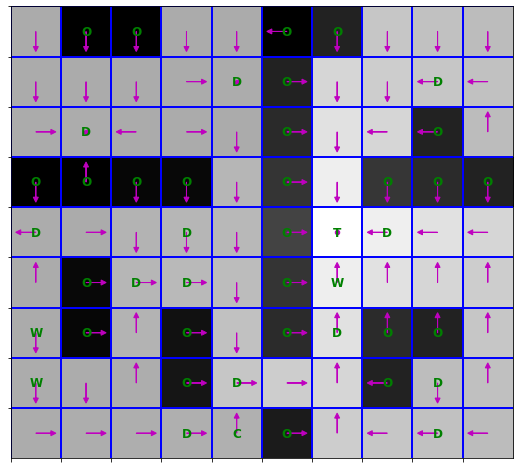

In [6]:
robo_mdp_finite = RoboMDP(discount=0.8, stochastic=False)
v_finite, pi_finite = policy_iteration(robo_mdp_finite, 8, make_grader(expected_output_pi_finite))

plot_v_pi(v_finite[-1], pi_finite[-1], robo_mdp_finite)

## 4 c) Infinite Horizon Problem

Iteration |  max|V-Vprev|  | # chg actions | V[0]    
----------+----------------+---------------+---------
   0      |   3079.13046   |      0        | -1012.668
   1      |   2079.13046   |     55        |   -0.000
   2      |    400.00000   |     24        |    5.120
   3      |    312.80000   |     14        |    5.120
   4      |    200.70400   |      5        |    5.120
   5      |    158.25920   |      5        |    5.120
   6      |     98.53082   |      5        |    5.120
   7      |     77.22465   |      4        |    5.120
   8      |     46.54378   |      7        |    5.120
   9      |     35.63502   |      7        |    5.120
  10      |     19.92641   |      4        |   15.322
  11      |      1.60000   |      1        |   15.322
  12      |      0.00000   |      0        |   15.322
Test succeeded


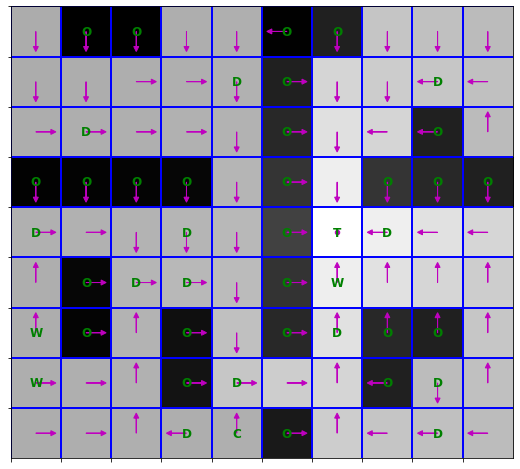

In [7]:
robo_mdp_infinite = RoboMDP(discount=0.8, stochastic=False)
v_infinite, pi_infinite = policy_iteration(robo_mdp_infinite, 100, make_grader(expected_output_pi_infinite))

plot_v_pi(v_infinite[-1], pi_infinite[-1], robo_mdp_infinite)

## 4 d) Infinite Horizon Problem with Stochastic Transitions

Iteration |  max|V-Vprev|  | # chg actions | V[0]    
----------+----------------+---------------+---------
   0      |   3165.92131   |      0        | -981.669
   1      |   1796.48425   |     48        | -122.211
   2      |    223.81262   |     23        |   -0.000
   3      |    185.24409   |      4        |    1.298
   4      |     27.21369   |      2        |    1.306
   5      |      4.48156   |      2        |    1.306
   6      |      3.42216   |      0        |    1.306
   7      |      0.00001   |      0        |    1.306
Test succeeded


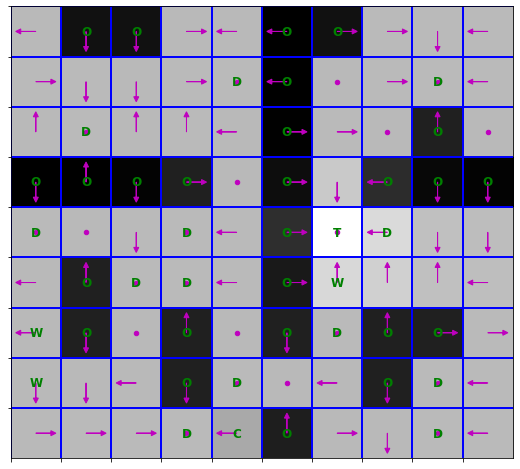

In [8]:
robo_mdp_finite_stoch = RoboMDP(discount=0.8, stochastic=True)
v_finite_stoch, pi_finite_stoch = policy_iteration(robo_mdp_finite_stoch, 100, make_grader(expected_output_pi_infinite_stoch))

plot_v_pi(v_finite_stoch[-1], pi_finite_stoch[-1], robo_mdp_finite_stoch)